# Mass Balance Automation

### Aniket Chitre, University of Cambridge 

This Jupyter notebook helps you digitally communicate with Metler Toledo's MS303TS/00 precision balance. This notebook is being shared as part of the application note on how to integrate a mass balance with the Opentrons OT-2 robot. You will run your Opentrons protocol separately and simulataneously have this notebook running in the background to log the data from the mass balance. The data can be exported & used for further analysis as intended.

## 0. Import Packages

In [ ]:
%matplotlib notebook
import matplotlib.animation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import serial
import csv

## 1. Port for Mass Balance

Find the port number on Windows through Device Manager or on Mac by running this command (`ls /dev/tty.*`) on the Terminal

In [ ]:
port = '/dev/tty.usbserial-14130' # Mac
#port = 'COM5' # Windows 

## 2. Data Collection  - run the cells in 2.1 or 2.2, not both

Please select the time interval (in seconds) for the mass data to be logged to. Additionally, select whether you wish for only the stable readings from the balance to be reported back in which case there will be a noticeable lag between the real and recorded time. This is because instead of the balance's reading being reported every 2 seconds (if that is the requested interval), the reading will only be recorded when stable, which can be > the requested time interval. If you wish to have a real-time mass profile, please select `stable=False`.

In [ ]:
time_interval = 2 # seconds
stable = False

This notebook provides a couple of options for automatically logging the data from the connected mass balance. 

1. Live animated mass vs. time graph
2. Saving the data without plotting

The first option provides an animated graph using Matplotlib's `FuncAnimation` method, or you can simply store the data, which can be plotted/used later. If performing a longer run, please ensure your computer does not go to sleep during the protocol operation. 

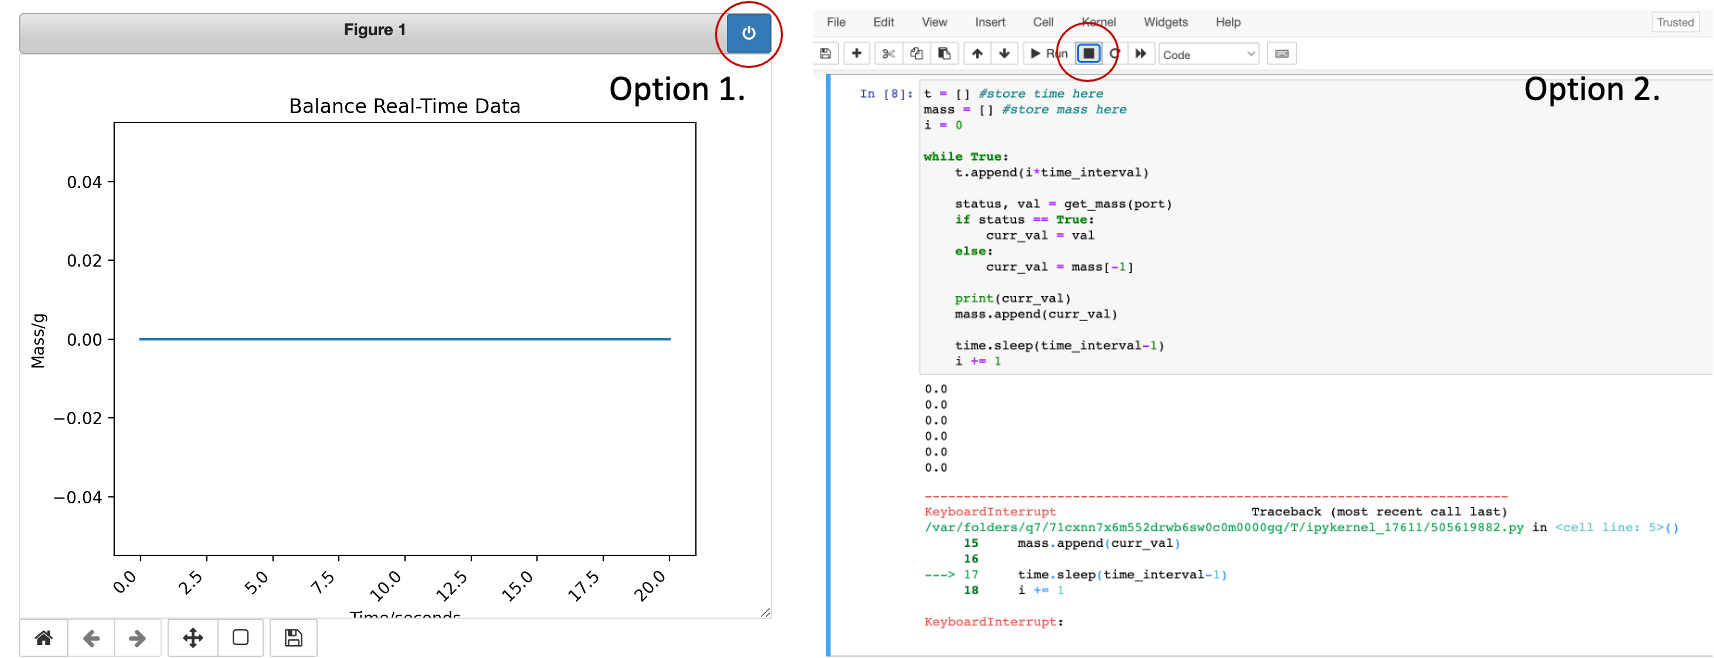

To stop the run with option 1, please press the "off" button highlighted in the screenshot above. Likewise, to end data logging with option 2, you will need to interupt the kernel and then proceed to run the cells in section #3 to view and save the data.

### 2.1 Live Animated Mass Data Logging

In [ ]:
# Create figure for plotting
fig  = plt.figure()
ax   = fig.add_subplot(1, 1, 1)
t    = [] #store time here 
mass = [] #store mass here
i = 0  

# function to obtain the mass reading from the balance as a serial object
def get_mass(port):
    balance = serial.Serial(port, 9600, xonxoff=True) # check COM port and xonxoff (handshake) = True default for MT balance
    if stable == True:
        balance.write('S\r\n'.encode('utf-8'))
    else:
        balance.write('SI\r\n'.encode('utf-8'))
    result  = balance.read_until('\r\n'.encode('utf-8'))
    mass    = float(result[7:14])
    return mass # result in g 

def animate(i,t,mass):
    t.append(i*time_interval)
    mass.append(get_mass(port))
    
    ax.clear()
    ax.plot(t, mass)
    
    # Format plot
    plt.xticks(rotation=45, ha='right');
    #plt.subplots_adjust(bottom=0.30)
    plt.title('Balance Real-Time Data');
    plt.xlabel('Time/seconds');
    plt.ylabel('Mass/g');
    
# Set up plot to call animate() function periodically
ani = matplotlib.animation.FuncAnimation(fig, animate, fargs=(t, mass), interval=1000*(time_interval))

### Or 2.2: Recording the Mass Data

In [ ]:
def get_mass(port):
    try:
        balance = serial.Serial(port, 9600, xonxoff=True) # check COM port and xonxoff (handshake) = True default for MT balance
        if stable == True:
            balance.write('S\r\n'.encode('utf-8'))
        else:
            balance.write('SI\r\n'.encode('utf-8'))
        time.sleep(1)
        result  = balance.read_until('\r\n'.encode('utf-8'))
        value = str(result[7:14].decode("utf-8"))
        #balance.close()
        if (value.strip() != '-------') and (value.strip() != ''):
            return (True,float(value))
        return (False,-1)
    except:
        return (False,-1)

In [ ]:
t = [] #store time here 
mass = [] #store mass here
i = 0

while True:
    t.append(i*time_interval)
    
    status, val = get_mass(port)
    if status == True:
        curr_val = val
    else:
        curr_val = mass[-1]
        
    print(curr_val)
    mass.append(curr_val)
    
    time.sleep(time_interval-1) # -1 because you also time.sleep(1) in the get_mass function definition.
    i += 1

### 3. Exporting the Data

In [ ]:
results = {'Time': t, 'Mass': mass}

In [ ]:
mass_df = pd.DataFrame(results)
mass_df

In [ ]:
sns.lineplot(x='Time', y='Mass', data=mass_df);

In [ ]:
file_name = "TestSample-DDMMYY.csv"

In [ ]:
mass_df.to_csv(file_name)